In [1]:
##Ridge regression 

import os
import matplotlib.pyplot as plt
import numpy as np
import scripts.implementations as lib  # Add personal library
import scripts.proj1_helpers as helper  # Add personal library

%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

DATA_FOLDER = 'data'
DATA_TRAIN = os.path.join(DATA_FOLDER, 'train.csv')
DATA_TEST = os.path.join(DATA_FOLDER, 'test.csv')

y, x, ids, header = helper.load_csv_data(DATA_TRAIN)
y_train, x_train,  y_validation, x_validation = lib.sep_valid_train_data(x,y, 0.8);
N = 1000

y_train = np.expand_dims(y_train[:N], axis=1)
x_train = x_train[:N]
y_validation = np.expand_dims(y_validation[:N], axis=1)
x_validation = x_validation[:N]


In [2]:
x_train[x_train == -999] = np.nan
x_validation[x_validation == -999] = np.nan

In [3]:
for i, feature in enumerate(x_train.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Feature 1 - DER_mass_MMC has range: [15.3870, 685.7010]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0710, 426.2370]
Feature 3 - DER_mass_vis has range: [13.0000, 529.5010]
Feature 4 - DER_pt_h has range: [0.1020, 509.6950]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0170, 7.3970]
Feature 6 - DER_mass_jet_jet has range: [33.9890, 2285.6570]
Feature 7 - DER_prodeta_jet_jet has range: [-13.3980, 11.3740]
Feature 8 - DER_deltar_tau_lep has range: [0.4520, 5.3210]
Feature 9 - DER_pt_tot has range: [0.0370, 215.5600]
Feature 10 - DER_sum_pt has range: [47.1170, 1282.5230]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.1380, 10.1490]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0010, 381.6290]
Feature 15 - PRI_tau_eta has range: [-2.4860, 2.4630]
Feature 16 - PRI_tau_phi has range: [-3.1350, 3.1350]
Feature 17 - PRI_lep_pt has range: [26.1050, 306.6340]
Feat

16.1565
[  22.175    27.3595   16.1565   32.294     1.156   139.223     1.451
    0.591     8.693    49.5995    0.434     0.9215    0.418     8.314
    0.909     1.593     9.4345    1.0265    1.6145   16.0235    1.6605
   60.0805    1.       24.974     1.309     1.485    10.352     1.646
    1.523    39.939 ]


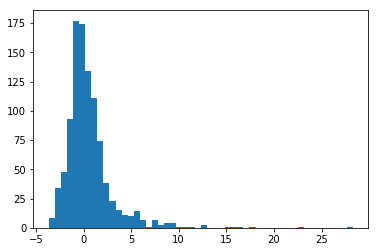

In [42]:
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

def mad_3(x_feat):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    mad_res = np.ones(x_feat.shape[1])
    for i, col in enumerate(x_feat.T):
        arr = np.ma.array(col).compressed() # should be faster to not use masked arrays.
        med = np.nanmedian(arr)
        mad_res[i] = np.nanmedian(np.abs(arr - med))

    return mad_res

# plt.hist(x_train[:,2], bins=50)
x_t = x_train[:,2].copy()
x_t[x_t > 250] = 0
#print(np.std(x_t))
#print(np.std(x_train[:,2]))
print(mad(x_train[:,2]))
print(mad_3(x_train))
#print('')
#print(np.mean(x_t))
#print(np.mean(x_train[:,2]))
#print(np.median(x_train[:,2]))

plt.hist((x_train[:,2]-np.median(x_train[:,2]))/mad(x_train[:,2]), bins=50)
plt.show()

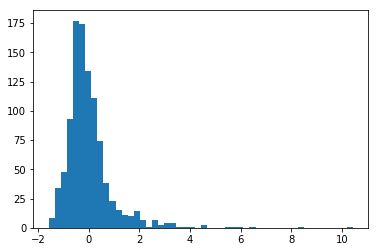

In [38]:
plt.hist((x_train[:,2]-np.mean(x_train[:,2]))/np.std(x_train[:,2]), bins=50)
plt.show()

## Ridge with no_nan


In [4]:
# normalize features
x_no_nan = x_train.copy()
x_no_nan = (x_no_nan - np.nanmean(x_no_nan, axis=0))/np.nanstd(x_no_nan, axis=0)
x_no_nan = np.nan_to_num(x_no_nan)
print('\nStd:', np.std(x_no_nan, axis=0))

# normalize features
x_no_nan_val = x_validation.copy()
x_no_nan_val = (x_no_nan_val - np.nanmean(x_no_nan_val, axis=0))/np.nanstd(x_no_nan_val, axis=0)
x_no_nan_val = np.nan_to_num(x_no_nan_val)
print('\nStd:', np.std(x_no_nan_val, axis=0))


Std: [ 0.9127  1.      1.      1.      0.5357  0.5357  0.5357  1.      1.      1.
  1.      1.      0.5357  1.      1.      1.      1.      1.      1.      1.
  1.      1.      1.      0.7829  0.7829  0.7829  0.5357  0.5357  0.5357
  1.    ]

Std: [ 0.9149  1.      1.      1.      0.5357  0.5357  0.5357  1.      1.      1.
  1.      1.      0.5357  1.      1.      1.      1.      1.      1.      1.
  1.      1.      1.      0.7701  0.7701  0.7701  0.5357  0.5357  0.5357
  1.    ]


In [8]:
def sigmoid(t):
    """apply sigmoid function on t."""
    return 1/(1+np.exp(-t))

def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    ypred = sigmoid(tx.dot(w))
    return -np.sum(y*np.log(ypred) + (1-y)*np.log(1-ypred))

def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    pred = sigmoid(tx.dot(w))
    return tx.T.dot(pred-y)

def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss and gradient."""
    loss = calculate_loss(y, tx, w) + lambda_ * np.squeeze(w.T.dot(w))
    
    batch_size = 100
    (y_st, tx_st) = [batch for batch in lib._batch_iter(y, tx, batch_size)][0]
    grad = calculate_gradient(y_st, tx_st, w) + 2 * lambda_ * w  # Derivate of term
    return loss, grad

def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.
    """
    loss, grad = penalized_logistic_regression(y, tx, w, lambda_)
    w -= gamma * grad
    return loss, w

def logistic_regression_gradient_descent_demo(x, y, x_val, y_val, degrees):
    # init parameters
    max_iter = 10000
    threshold = 1e-8
    gamma = 1e-3
    
    degrees = np.linspace(1,2,2).astype(int)
    lambdas = np.logspace(1,7,20)
    
    acc_train = np.zeros((len(degrees), len(lambdas)))
    acc_val = np.zeros((len(degrees), len(lambdas)))
    acc_loss = np.zeros((len(degrees), len(lambdas)))
    
    _y = (y+1)/2
    _y_val = (y_val+1)/2

    
    # Get ploynomial

    for i, degree in enumerate(degrees):
        
        phi_train = lib.build_poly(x, degree)
        phi_test = lib.build_poly(x_val, degree)
        w = np.zeros((phi_train.shape[1], 1))
        
        for j, lambda_ in enumerate(lambdas):
            losses = []
            # start the logistic regression
            for iter in range(max_iter):
                # get loss and update w.
                loss, w = learning_by_penalized_gradient(_y, phi_train, w, gamma, lambda_)
                # converge criterion
                losses.append(loss)
                if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
                    break
            acc_train[i, j] = lib.accuracy(y, phi_train.dot(w))
            acc_val[i, j] = lib.accuracy(y, phi_test.dot(w))
            acc_loss[i, j] = losses[-1]
            print('validation acc deg={} lam={} loss={}: {:.4f}, {:.4f}'.format(
                degree, lambda_, acc_loss[i, j], acc_val[i, j], acc_train[i, j]))

    print('validation MAX acc: {:.6f}'.format(np.max(acc_val)))
logistic_regression_gradient_descent_demo(x_no_nan, y_train, x_no_nan_val, y_validation, degrees=1)


validation acc deg=1 lam=10.0 loss=551.5785396238977: 0.5560, 0.7450
validation acc deg=1 lam=20.6913808111479 loss=584.3543076815613: 0.5600, 0.7420
validation acc deg=1 lam=42.81332398719393 loss=621.6680062599812: 0.5390, 0.7420
validation acc deg=1 lam=88.58667904100822 loss=649.1770871668065: 0.5620, 0.7300
validation acc deg=1 lam=183.29807108324357 loss=667.229694159798: 0.5200, 0.7290
validation acc deg=1 lam=379.26901907322497 loss=681.9457627407514: 0.5740, 0.7020
validation acc deg=1 lam=784.7599703514607 loss=692.8326523649348: 0.5350, 0.6140


/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/abbet/anaconda3/envs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: overflow encountered in multiply


validation acc deg=1 lam=1623.776739188721 loss=nan: 0.0000, 0.0000
validation acc deg=1 lam=3359.818286283781 loss=nan: 0.0000, 0.0000
validation acc deg=1 lam=6951.927961775606 loss=nan: 0.0000, 0.0000
validation acc deg=1 lam=14384.498882876629 loss=nan: 0.0000, 0.0000
validation acc deg=1 lam=29763.51441631313 loss=nan: 0.0000, 0.0000


KeyboardInterrupt: 

## Submission


In [ ]:
y_test, x_test, ids_test, header = helper.load_csv_data(DATA_TEST)
x_test[x_test == -999] = np.nan

x_no_nan_test = x_test.copy()
x_no_nan_test = (x_no_nan_test - np.nanmean(x_no_nan_test, axis=0))/np.nanstd(x_no_nan_test, axis=0)
x_no_nan_test = np.nan_to_num(x_no_nan_test)
print('\nStd:', np.std(x_no_nan_test, axis=0))


In [ ]:
degree_opt = degree_no_nan
weights_opt = weights_no_nan

_phi_test = lib.build_poly(x_no_nan_test, degree_opt)
y_pred = helper.predict_labels(weights_opt, _phi_test)




In [ ]:
helper.create_csv_submission(ids_test, y_pred, 'ridge_no_nan1.csv')
print('Results saved ...')